# Plotting elasticity and accoustic velocities at high PT with `qha-cij`

This tutorial demostrate how to programmingly invoke `qha-cij` package in Python, and how to plot with it.

## Load the configuration and run the `Calculator`

In [1]:
import cij.core.calculator


calculator = cij.core.calculator.Calculator("_attachments/delta/config.yml")

/Users/chazeon/Documents/Projects/qha-cij-2/cij/core/phonon_contribution/nonshear.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return  h_div_k * (self.freq_array[nax,:,:,:] / self.t_array[:,nax,nax,nax])
/Users/chazeon/Documents/Projects/qha-cij-2/cij/core/phonon_contribution/nonshear.py:119: RuntimeWarning: invalid value encountered in true_divide
  return  h_div_k * (self.freq_array[nax,:,:,:] / self.t_array[:,nax,nax,nax])
/Users/chazeon/Documents/Projects/qha-cij-2/cij/core/phonon_contribution/nonshear.py:141: RuntimeWarning: invalid value encountered in true_divide
  return self.Q ** 2 * numpy.exp(self.Q) / (numpy.exp(self.Q) - 1) ** 2
/Users/chazeon/Documents/Projects/qha-cij-2/cij/core/phonon_contribution/nonshear.py:130: RuntimeWarning: invalid value encountered in true_divide
  return self.Q / (numpy.exp(self.Q) - 1)


## Plotting elastic moduli

Here we prepare a plot for $c_{ij}$ for forsterite.

First let's setup matplotlib

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import numpy

Prepare the color map from temperature to color

In [3]:
from cij.plot import color_x

cmap = color_x(-5, 1500)

Now we get the pressures `p_array` and temperature array `t_array`.

In [4]:
from cij.util import units

p_array = units.Quantity(
    calculator.qha_calculator.pressure_base.p_array,
    units.rydberg / units.bohr ** 3).to(units.GPa).magnitude
t_array = calculator.qha_calculator.t_array

p_indices = calculator.qha_calculator.pressure_base.volumes < numpy.max([
        volume.volume for volume in calculator.qha_input.volumes
    ])
p_indices = numpy.ones(calculator.qha_calculator.pressure_base.volumes.shape, dtype=bool)

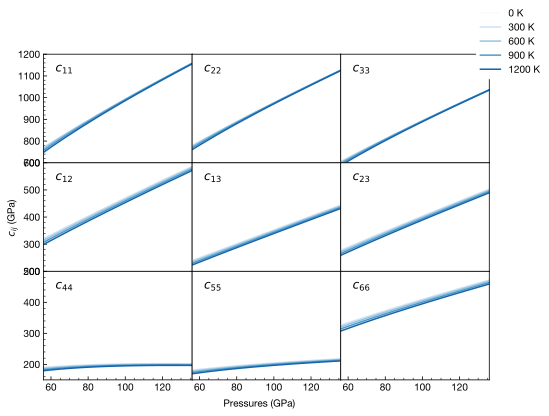

In [5]:
from cij.util import c_

fig, axes = plt.subplots(3, 3, sharex=True, figsize=(8, 6))

keys = {
    c_(11): (0,0),
    c_(22): (0,1),
    c_(33): (0,2), 
    c_(12): (1,0),
    c_(13): (1,1),
    c_(23): (1,2), 
    c_(44): (2,0), 
    c_(55): (2,1), 
    c_(66): (2,2), 
}

ylims = [(700, 1200), (200, 600), (150, 500)]

for key, (j, k) in keys.items():
    ax = axes[j, k]
    moduli = units.Quantity(
        calculator.pressure_base.v2p(calculator.modulus_adiabatic[key]),
        units.rydberg / units.bohr ** 3).to(units.GPa).magnitude
    for i in range(0, t_array.shape[0], 3):
        t = t_array[i]
        ax.plot(p_array[p_indices[i,:]], moduli[i, p_indices[i,:]], label=f"{t} K", c=cmap(t))

    ax.set_ylim(*ylims[j])
    ax.set_xlim(min(p_array), max(p_array))
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    if j != 2: ax.xaxis.set_visible(False)
    if k != 0: ax.yaxis.set_visible(False)
    
    ax.text(.08, .92,"$c_{%d%d}$" % key.v, transform=ax.transAxes, fontsize=12, ha='left', va="top")
    

fig.legend([
    matplotlib.lines.Line2D([], [], color=cmap(t))
    for t in t_array[::3]
], [f"{t} K" for t in t_array[::3]])

fig.text(0.5, 0.08, "Pressures (GPa)", ha="center", va="top")
fig.text(0.08, 0.5, "$c_{ij}$ (GPa)", rotation=90, va="center", ha="right")

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Plotting accoustic velocities

Next we plot primary velocities $v_\text{s}$ and secondary velocities $v_\text{p}$

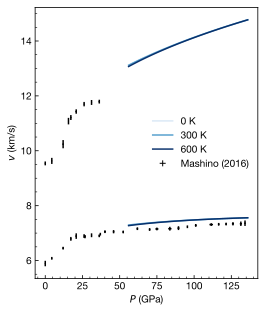

In [20]:
plt.figure(figsize=(4, 5))
from matplotlib.lines import Line2D

cmap = color_x(-100, 600)

for velocity in [
    calculator.pressure_base.primary_velocities,
    calculator.pressure_base.secondary_velocities
]:

    for i in [0, 3, 6]:
        t = t_array[i]
        plt.plot(
            p_array[p_indices[i,:]],
            velocity[i, p_indices[i,:]],
            label=f"{t} K", c=cmap(t)
        )

plt.legend(
    [Line2D([], [], c=cmap(t)) for t in [0, 300, 600]] + [
        Line2D([], [], c="k", ls="", marker="+")
    ],
    [f"{t} K" for t in [0, 300, 600]] + [
        "Mashino (2016)"
    ],
)


from parse_mashino import get_exp_vp, get_exp_vs

_p_array, p_err_array, vp_array, vp_err_array = zip(*get_exp_vp())
plt.errorbar(_p_array, vp_array, yerr=vp_err_array, xerr=p_err_array, c="k", fmt="+", markersize=1)

_p_array, p_err_array, vp_array, vp_err_array = zip(*get_exp_vs())
plt.errorbar(_p_array, vp_array, yerr=vp_err_array, xerr=p_err_array, c="k", fmt="+", markersize=1)

plt.xlabel("$P$ (GPa)")
plt.ylabel(r"$v$ (km/s)")
# plt.ylim(3.5, 10.5)
# plt.xlim(-1, 15)

plt.show()

## Plotting with plotter

In [ ]:
from cij.plot import Plotter

plotter = Plotter(calculator)

plt.figure()

for t in range(100, 2500, 300):
    
    plotter.plot_cij_p(plt.gca(), 11, t, c=cmap(t), label=f"{t} K")
    
plt.xlim(1, 12)
# plt.ylim(200, 800)

plt.legend()

plt.show()

In [ ]:
from cij.plot import Plotter

plotter = Plotter(calculator)

plt.figure()

for t in range(100, 2500, 300):
    
    _plot = lambda p_array, c_array: plt.plot(p_array, c_array, c=cmap(t), label=f"{t} K")
    
    plotter.plot_cij_p_with(_plot, 11, t)
    
plt.xlim(1, 12)

plt.legend()

plt.show()

In [ ]:
from cij.plot import Plotter

plotter = Plotter(calculator)

plt.figure()

p = 0

for _key, _plot in [
    (11, lambda p_array, c_array: plt.plot(p_array, c_array, label=r"$c_{11}$")),
    (33, lambda p_array, c_array: plt.plot(p_array, c_array, label=r"$c_{33}$")),
    (22, lambda p_array, c_array: plt.plot(p_array, c_array, label=r"$c_{22}$")),
    (23, lambda p_array, c_array: plt.plot(p_array, c_array + 35, label=r"$c_{23}+35$")),
    (13, lambda p_array, c_array: plt.plot(p_array, c_array +  0, label=r"$c_{13}$")),
    (12, lambda p_array, c_array: plt.plot(p_array, c_array - 25, label=r"$c_{12}-25$")),
]:
    
    plotter.plot_cij_t_with(_plot, _key, p)
    
plt.xlim(0, 2200)
plt.ylim(0, 350)

plt.legend()

plt.show()

plt.figure()

p = 0

for _key, _plot in [
    (44, lambda p_array, c_array: plt.plot(p_array, c_array +  0, label=r"$c_{44}$")),
    (55, lambda p_array, c_array: plt.plot(p_array, c_array + 10, label=r"$c_{55}+10$")),
    (66, lambda p_array, c_array: plt.plot(p_array, c_array +  0, label=r"$c_{66}$")),
]:
    
    plotter.plot_cij_t_with(_plot, _key, p)
    
plt.xlim(0, 2200)
plt.ylim(30, 125)

plt.legend()

plt.show()